# Lab 2

The aims of the lab are to:
*   Learn to use SciKit learn to vectorize text with a bag-of-words representation
*   Use Cosine similarity to find similar documents in a collection. 
*   Perform KMeans clustering on Reddit posts
*   Perform an evaluation of clustering and possibly improve it



## Reddit Data Review

**Thread fields**
*   URL - reddit URL of the thread
*   title - title of the thread, as written by the first poster
*   is_self_post - True if the first post in the thread is a self-post (text addressed to the reddit community as opposed to an external link)
*   subreddit - the subreddit of the thread
*   posts - a list of all posts in the thread

**Post fields**
*   id - post ID, reddit ID of the current post
*   body - the text of the post
*   in_reply_to - parent ID, reddit ID of the parent post, or the post that the current post is in reply to
*   post_depth - the number of replies the current post is from the initial post
*   is_first_post - True if the current post is the initial post


Download the Reddit dataset.  

In [0]:
# The local location to store the reddit dataset.
local_file = "coarse_discourse_dump_reddit.json"

!gsutil cp gs://textasdata/coarse_discourse_dump_reddit.json $local_file
  
# The ! performs a shell command to download the reddit dataset using wget.
#!wget -O  $local_file https://storage.googleapis.com/tad2018/coarse_discourse_dump_reddit.json


Copying gs://textasdata/coarse_discourse_dump_reddit.json...
- [1 files][ 78.5 MiB/ 78.5 MiB]                                                
Operation completed over 1 objects/78.5 MiB.                                     


Load the JSON data into DataFrame with each post as a row.

In [0]:
# The reddit thread structure is nested with posts in a new content.
# This block reads the file as json and cates a new data frame.
import pandas as pd
import json

# A temporary variable to store the list of post content.
posts_tmp = list()

with open(local_file) as jsonfile:
  for i, line in enumerate(jsonfile):
    thread = json.loads(line)
    for post in thread['posts']:
      # Keep the thread title and subreddit with each post.
      posts_tmp.append((thread['subreddit'], thread['title'], thread['url'],
                        post['id'], post.get('author', ""), post.get('body', "")))
print(len(posts_tmp))

# Create the posts data frame.  
labels = ['subreddit', 'title', 'id', 'url', 'author', 'body']
post_frame = pd.DataFrame(posts_tmp, columns=labels)

110595


### Import spacy

In [0]:
!python -m spacy download en

import spacy

import sys
print(sys.version)

# Version checks
import importlib
def version_check(libname, min_version):
    m = importlib.import_module(libname)
    print ("%s version %s is" % (libname, m.__version__))
    print ("OK" if m.__version__ >= min_version 
           else "out-of-date. Please upgrade!")
    
version_check("spacy", "2.0")

# Load the small english model. 
# Disable the advanced NLP features in the pipeline for efficiency.
nlp = spacy.load('en_core_web_sm', disable=['ner'])
print(nlp.pipeline)
print(nlp.pipe_names)
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')
# Verify they are empty.
print(nlp.pipeline)


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
spacy version 2.1.9 is
OK
[('tagger', <spacy.pipeline.pipes.Tagger object at 0x7fde42ce4e10>), ('parser', <spacy.pipeline.pipes.DependencyParser object at 0x7fde428f4588>)]
['tagger', 'parser']
[]


### SpaCy Tokenization

In [0]:
def spacy_tokenize(string):
  tokens = list()
  doc = nlp(string)
  for token in doc:
    tokens.append(token)
  return tokens

# This tokenizes the body posts and creates vector of tokens for each post.
# Note: This selections the body column from the posts only. 
all_posts_tokenized = post_frame.body.apply(spacy_tokenize)

import itertools
# A single variable with the (flattened) tokens from all posts.
flat_tokens = list(itertools.chain.from_iterable(all_posts_tokenized))

In [0]:
def normalize(tokens):
  normalized = list()
  for token in tokens:
    if (token.is_alpha or token.is_digit):
      lemma = token.lemma_.lower().strip() if token.lemma_ != "-PRON-" else token.lower_
      normalized.append(lemma)
  return normalized

In [0]:
normalized_tokens = normalize(flat_tokens)

## Vector representations with Scikit-Learn

#### Warning: Large-ish data ahead!
The complete Reddit dataset may be **slow** to run for some of these simple clustering algorithms.  If you encounter issues, you should limit the number of posts you analyze.  The focus should be on running algorithms, not waiting for them to complete. 

In [0]:
# Limit the size of the data loaded
# Recall that there is approximately 110k posts in the dataset.
posts_to_load = 25000

Scikit-learn is a widely machine learning library that includes tools for performing operations on data: similarity computation, clustering, classification, and many others. We'll use Scikit-learn to create vector representations of text data.

In [0]:
from itertools import islice

# Parallel arrays of the post keys and values.
post_vals = list()
post_keys = list()

for post in islice(post_frame.itertuples(index=True, name='Pandas'), posts_to_load):
    post_keys.append(getattr(post, 'id'))
    post_vals.append(getattr(post,'body'))

#### Your task
Create a document-term matrix with a one-hot encoding from the collection using the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). This will have the following steps:
 - Import the ``CountVectorizer`` and create an instance; assign it to a variable, ``onehot_vectorizer``
 - All scikit learn vectorizers accept a tokenizer as an optional parameter (it has a built-in tokenizer).  Pass in the ``tokenize_normalize`` function to ``CountVectorize (tokenizer=...)`` created earlier. 
 - Use the parameter `binary=True` to create a one-hot-encoding representation (the default is bag-of-words with counts). 
 - Call ``fit`` on the ``post_vals`` variable to learn a vocabulary
 - ``Transform`` the ``post_vals`` into a document-term matrix, assign it to a variable, `onehot_document_term_matrix`.

In [0]:
def tokenize_normalize(string):
  return normalize(spacy_tokenize(string))

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

onehot_vectorizer = CountVectorizer(tokenizer=tokenize_normalize, binary=True)
onehot_vectorizer.fit(post_vals)
onehot_document_term_matrix = onehot_vectorizer.transform(post_vals)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


What just happened?
 - The `fit()` function tokenized the text collection and built a vocabulary/dictionary 
 - The `transform()` function created a document-term matrix with a one-hot document vector representation.
 
 These steps are sometimes combined together with the single step called ``fit_transform``. 

Let's now apply the vectorizer on new unseen text.  We do this by calling `transform` on the raw string (the tokenizer is a member of the vectorizer class). 


In [0]:
mystring = 'The next town over recently got a brand new flagship Lidl – now my town is getting a brand new flagship Aldi. I fear war.'
response = onehot_vectorizer.transform([mystring])
print (response)

  (0, 596)	1
  (0, 2727)	1
  (0, 3523)	1
  (0, 9073)	1
  (0, 9402)	1
  (0, 10338)	1
  (0, 12165)	1
  (0, 16521)	1
  (0, 16864)	1
  (0, 16890)	1
  (0, 17181)	1
  (0, 17862)	1
  (0, 20274)	1
  (0, 24726)	1
  (0, 25238)	1
  (0, 26923)	1


What is the output here? 
 - (0, 303) 1 
 - There are three fields: `(row, column) term_frequency`. 
 - We see a simple document-term matrix represented as a list of sparse columns.
 
 
 What happened? 
 - Transform applies the vectorizor, just like ``tokens_to_ids`` in our dictionary implementation.  
 - The vectorizer creates a document-term matrix with the result, in this case a sparse-one hot encoding. 
 
**Question:** We did not call ``fit``.  Why? What would this have done?

### From ids to tokens
The ``inverse_transform`` is just like ``ids_to_tokens`` in Lab 1 applied to every non-UNK value (which are not invertable!).  

In [0]:
print (onehot_vectorizer.inverse_transform(response))

[array(['a', 'be', 'brand', 'fear', 'flagship', 'get', 'i', 'my', 'new',
       'next', 'now', 'over', 'recently', 'the', 'town', 'war'],
      dtype='<U152')]




In the inverse output, can see that some of the words are not present (e.g. lidl, aldi, etc...). These are ignored; calling ``transform()`` does not update our vocabulary and there is no UNK representation in this vocabulary.  Scikit-Learn ignores all tokens in its vocabulary. Note, this has important ramifications for deploying an SKLearn classififier where there may be significant numbers of new or unknown terms.

**Question**: What could you do to monitor the possible impact of a fixed model applied to new text over time?

#### Your task 
- Create a TF-IDF vectorizer and apply it to the ``post_vals`` similar to what was done for CountVectorizer. 
 - Use the [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).
 - Set `sublinear_tf` = True to use the log scaling (as opposed to natural TF counts)
 - Use our previously defined `tokenize_normalize` function as the tokenizer
 - Create n-grams of up to length 2 (unigrams and bigrams)
 - Limit the number of features (the size of the vocabulary) to 50000
 - Assign it to a ``ngram_vectorizer`` variable
 - Apply the vectorizer and create a TF-IDF document-term matrix, assign it to a variable: `ngram_document_term_matrix` 


#### Log scaling
- What is the log base used by SKLearn?  
 
Read the documentation of the vectorizer for details on the parameters as needed.  Warning: if this takes too long, or crashes then your configuration is wrong.


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

ngram_vectorizer = TfidfVectorizer(tokenizer=tokenize_normalize, sublinear_tf=True, ngram_range=(1, 2))
ngram_document_term_matrix = ngram_vectorizer.fit_transform(post_vals)

#### Test the vectorizer

Apply the vectorizer on our sample string.  Notice the weights are different from the base one-hot encoding vectorizer.

In [0]:
my_string = 'The next town over recently got a brand new flagship Lidl – now my town is getting a brand new flagship Aldi. I fear war.'
ngram_matrix = ngram_vectorizer.transform([my_string])
print (ngram_matrix)

  (0, 314890)	0.13647500868385956
  (0, 300636)	0.235056133924534
  (0, 300601)	0.20683272424186794
  (0, 300591)	0.24149014059463958
  (0, 284462)	0.1347044538600833
  (0, 280448)	0.038107879224110915
  (0, 234370)	0.19468970960920134
  (0, 234339)	0.1315329987962153
  (0, 210560)	0.09849799307989683
  (0, 195256)	0.19879721926648117
  (0, 195067)	0.08678575505851518
  (0, 190762)	0.11416643393506502
  (0, 190057)	0.16615421339311426
  (0, 187076)	0.19468970960920134
  (0, 185384)	0.06349160790827396
  (0, 140248)	0.20382440479571984
  (0, 139774)	0.0390935507201874
  (0, 118919)	0.17399390153936153
  (0, 118877)	0.10637074975267134
  (0, 108015)	0.3979846304276457
  (0, 104324)	0.15697681110249856
  (0, 51061)	0.33295736404075854
  (0, 51044)	0.27444590502345284
  (0, 40945)	0.1395035788552959
  (0, 39467)	0.03670579720470778
  (0, 7372)	0.36303290836343166
  (0, 6638)	0.06644980990306107


We're just scratching the surface of what's possible.  There are other types of representations as well.  For example, there is a [HashingVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html) and others.
- What are the pros and cons of using HashingVectorizer vs TFIDFVectorizer?
- Question: What does ``fit()`` function do on the HashingVectorizer?  Why is this? Contrast it with the CountVectorizer.

## Cosine similarity
We will now use sklearn's cosine similarity implementation to find similar posts.

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
 
# A function that given an input query item returns the top-k most similar items 
# by their cosine similarity.
def find_similar(query_vector, td_matrix, top_k = 5):
    cosine_similarities = cosine_similarity(query_vector, td_matrix).flatten()
    related_doc_indices = cosine_similarities.argsort()[::-1]
    return [(index, cosine_similarities[index]) for index in related_doc_indices][0:top_k]

**Exercise:** Next, lets pick a post to compute similarity with. Put the content of a post in the variable called `my_string`

In [0]:
# Convenience variable to easily change the vectorizer and the document_matrix 
# to be a one-hot encoding or count representation. 
vectorizer = ngram_vectorizer
document_matrix = ngram_document_term_matrix

#post_index = 1000

# Or take the content of a post.
import random as rand
post_index = rand.randint(0, len(post_vals))
my_string = post_vals[post_index]
print(my_string.replace('\n', ''))

# Transform our string using the vocabulary
transformed = vectorizer.transform([my_string])

# The result of transformation is a document-term matrix, but  there is only one row.  
query_document = transformed[0:1]
print(query_document)

I think a quarry to fill the gap between easily collected stone and traders with stone is very useful. I don't care for them long term and usually only build one of them. 
  (0, 324798)	0.1692839897658291
  (0, 323361)	0.04789816477030198
  (0, 312142)	0.15525961891671522
  (0, 311740)	0.07448201267688423
  (0, 310180)	0.15525961891671522
  (0, 310062)	0.09361422373200126
  (0, 309829)	0.17325306669190782
  (0, 309811)	0.11654037769753456
  (0, 300997)	0.17325306669190782
  (0, 300985)	0.14751657233545123
  (0, 296331)	0.13741378278690466
  (0, 295231)	0.03282111669221847
  (0, 290842)	0.128327675728922
  (0, 290833)	0.05895166311784273
  (0, 288312)	0.1855821457288506
  (0, 288093)	0.11032484567027104
  (0, 282979)	0.1569549107288863
  (0, 280448)	0.03008703443517427
  (0, 276999)	0.16604101778686897
  (0, 276994)	0.10584252572210748
  (0, 268021)	0.1692839897658291
  (0, 268019)	0.15371193874992617
  (0, 268014)	0.21128901404891304
  (0, 229705)	0.1855821457288506
  (0, 229698)	0.153

Look at the top K most similar posts to the query document. 

In [0]:
top_k = 10
print ("\nsimilar:")
for index, score in find_similar(query_document, document_matrix, top_k):
  print(score, index, post_keys[index], post_vals[index].replace('\n', ''))


similar:
1.0000000000000004 8009 https://www.reddit.com/r/Banished/comments/1zn3c6/please_explain_your_expansion_strategy/ I think a quarry to fill the gap between easily collected stone and traders with stone is very useful. I don't care for them long term and usually only build one of them. 
0.18588234436603743 10950 https://www.reddit.com/r/DIY/comments/c99ey/ask_diy_what_are_some_good_kit_projects/ build one of these.http://imgur.com/6o9or.jpg
0.1851673941492641 10034 https://www.reddit.com/r/ClashOfClans/comments/2ewv03/idea_use_a_healer_on_defense_to_turn_skeletons/ That would be fun, but it wouldn't be very useful. I like it.
0.14862341282494937 8008 https://www.reddit.com/r/Banished/comments/1zn3c6/please_explain_your_expansion_strategy/ Thanks for the advice!  I'd like to do without quarries and mines if I can.  That's one reason why I have a problem with when to build the larger buildings--there's only so much stone to be had, and I have never once, in any game I've tried, b

What do you see?  If you use the post, it should find itself and return a similarity score of 1.0.

You my try fixing the post used as a query and then experiment with different vectorizers and matrix representations (count, tfidf, ngrams). 

- How do the most similar posts change?
- What do you think works best for the reddit post data? Why? 

## KMeans clustering

What's in the Reddit dataset? When we want to explore a dataset, one method is to apply clustering and then to inspect the result.


From the SKlearn documentation:
The [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields.

K-means is sometimes referred to as Lloyd’s algorithm. 

Recall from lecture: In basic terms, the algorithm has three steps. 
1) The first step chooses the initial centroids, with the most basic method being to choose k samples from the dataset X. 


After initialization, K-means consists of looping between the two other steps. The first assigns each sample to its nearest centroid. The second step creates new centroids by taking the mean value of all of the documents assigned to each centroid. The difference between the old and the new centroids are computed and the algorithm repeats until the centroids do not move significantly.


#### Your task
 - Run K-Means on the document-term matrix from TFIDF vectorization. 
  - Start with ``k=8`` clusters
  - Use KMeans with `'random'` cluster initialization
  - Add `verbose=10` to show the clustering progress
  - Limit the number of times kmeans will run with different seeds to `5` (or lower if it is taking a long time). 
  - Just like fitting a vocabulary, clustering is produced by calling ``fit``, but on the document-term matrix (not raw data), to fit clusters to do matrix. 
  - Assign the clustering result to a ``kmeans`` variable. 
  
 
 Note: Vanilla kmeans may be slow.
 If it is taking too (more than 5 minutes) stop it. You might need to use MiniBatchKMeans (below).



In [0]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, init='random', random_state=0, verbose=10).fit(ngram_document_term_matrix)

Initialization complete
Iteration  0, inertia 24101.000
Iteration  1, inertia 23875.740
Converged at iteration 1: center shift 0.000000e+00 within tolerance 2.857392e-10
Initialization complete
Iteration  0, inertia 47687.192
Iteration  1, inertia 23785.798
Iteration  2, inertia 23685.873
Iteration  3, inertia 23612.676
Iteration  4, inertia 23596.714
Iteration  5, inertia 23591.028
Iteration  6, inertia 23588.498
Iteration  7, inertia 23587.207
Iteration  8, inertia 23586.217
Iteration  9, inertia 23585.438
Iteration 10, inertia 23584.761
Iteration 11, inertia 23584.319
Iteration 12, inertia 23583.979
Iteration 13, inertia 23583.692
Iteration 14, inertia 23583.457
Iteration 15, inertia 23583.200
Iteration 16, inertia 23582.927
Iteration 17, inertia 23582.718
Iteration 18, inertia 23582.508
Iteration 19, inertia 23582.372
Iteration 20, inertia 23582.280
Iteration 21, inertia 23582.214
Iteration 22, inertia 23582.170
Iteration 23, inertia 23582.138
Iteration 24, inertia 23582.128
Iterat

**Question**: 
- Roughly how long did it take to run? 
- Is there much variance per iteration of clustering? If so, why do you think this may be?

#### Your task

- Perform the same clustering, but use [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html).
- Assign the result to `minibatch_kmeans`. 

**Questions**: 
- How would you select a batch size to use? 
- What are the trade-offs?
- What was used by Google for the web-scale k-means paper discussed in class.
- How does it compare with the SKLearn default?

In [0]:
from sklearn.cluster import MiniBatchKMeans
minibatch_kmeans = MiniBatchKMeans(n_clusters=8, init='random', random_state=0, batch_size=8)
minibatch_kmeans.fit(ngram_document_term_matrix)

MiniBatchKMeans(batch_size=8, compute_labels=True, init='random',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=8, n_init=3, random_state=0, reassignment_ratio=0.01,
                tol=0.0, verbose=0)

**Question:** Roughly how fast did it converge?  Compare this with the vanilla KMeans algorithm. 

#### Cluster centroids
We should now have a kmeans with cluster centers. Let's examine the centroids. We'll do this for the first KMeans clustering, but you can also do this for MiniBatchKMeans. 

Recall that centroids are **not** documents, they represent a typical example (**average**) document. 

We'll print out the top 10 terms from each of the centroids.

In [0]:
num_clusters = 8
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
  print("Cluster %d:" % i)
  for ind in order_centroids[i, :20]:
    print(' %s' % terms[ind])
  print()

Cluster 0:
 the
 be
 a
 to
 of
 i
 and
 it
 that
 in
 have
 for
 but
 they
 on
 do
 much
 with
 not
 my

Cluster 1:
 you
 be
 a
 to
 the
 do
 if you
 if
 it
 can
 you can
 your
 and
 have
 that
 do you
 i
 get
 for
 in

Cluster 2:
 the
 be
 a
 and
 it
 to
 that
 i
 for
 of
 in
 my
 on
 good
 not
 with
 thank
 have
 your
 he

Cluster 3:
 i
 do
 it
 be
 i do
 to
 a
 have
 the
 that
 and
 i be
 my
 but
 i have
 think
 yes
 get
 know
 like

Cluster 4:
 delete
 delete what
 what be
 what
 be
 ﻿1 you
 for travel
 for transaction
 for transcend
 for transcript
 for transfer
 for transformative
 for trap
 for trouble
 for treat
 for trump
 for truth
 for try
 for ttk
 for tube

Cluster 5:
 this
 be
 this be
 i
 the
 a
 to
 for
 it
 thank
 of
 and
 you
 have
 in
 one
 that
 be this
 post
 be a

Cluster 6:
 no
 no problem
 problem
 i
 no i
 have no
 be
 have
 i have
 it
 no one
 no it
 no idea
 the
 a
 to
 you
 there
 not
 idea

Cluster 7:
 thank
 thank you
 you
 thank man
 man
 cool thank
 than

We can also look at the cluster assignments.  Each post is assigned a cluster label. 

In [0]:
import collections
# Group the posts by their cluster labels.
clustering = collections.defaultdict(list)
for idx, label in enumerate(kmeans.labels_):
  clustering[label].append(idx)


In [0]:
for cluster, indices in clustering.items():
  print("\nCluster:", cluster, " Num posts: ", len(indices))
  cur_docs = 0
  for index in indices:
    if (cur_docs > 10):
      break
    post_contents = post_vals[index].replace('\n', '')
    print(index, post_keys[index], (post_contents[:75] + '..') if len(post_contents) > 75 else post_contents)
    cur_docs+=1


Cluster: 0  Num posts:  6654
0 https://www.reddit.com/r/100movies365days/comments/1bx6qw/dtx120_87_nashville/ 4/7/13  7/27/12  http://www.imdb.com/title/tt0073440/referenceIt was only a..
2 https://www.reddit.com/r/100movies365days/comments/1bx6qw/dtx120_87_nashville/ You strike me as the type who would appreciate it. I would give it a go. Th..
4 https://www.reddit.com/r/100sets/comments/omv7p/male_23_years_old_going_for_100_sets/ **January 16th 3 Sets:** Went out shopping with my grandma as I visited her..
8 https://www.reddit.com/r/100sets/comments/omv7p/male_23_years_old_going_for_100_sets/ Ok. Update! Sorry I haven't been doing this day to day like I should be. Le..
10 https://www.reddit.com/r/1200isplenty/comments/259tbh/122cal_black_currant_cheesecake/ I love cheese cake! I love both making and eating it, so I'm sad to see tha..
11 https://www.reddit.com/r/1200isplenty/comments/259tbh/122cal_black_currant_cheesecake/ >very specific items that aren't available everywhereI find th


*   Is the clustering useful to explore the data?
*   Can you label the clusters?
*   Are these 'good' clusters?

### Create a better clustering

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

Try to create a better clustering than the one above. You may use any variety of parameters you wish. A few ideas are below.   
 - Try using kmeans++ instead of random
 - Vary the number of clusters (k)

You might also try: 
 - Try varying the representation (one-hot encoding)
 - Try varying the similarity function ([jaccard](https://scikit-learn.org/stable/modules/model_evaluation.html#jaccard-similarity-score), etc...) 

In [0]:
# Example cluster range
cluster_range = [4, 8, 16, 32, 64, 128]

### Sample code to plot the Silhouette coefficients for the clusters

Starting iteration 4
For n_clusters = 4 The average silhouette_score is : 0.006108321832953245
Starting iteration 8
For n_clusters = 8 The average silhouette_score is : 0.006108321832953245
Starting iteration 16
For n_clusters = 16 The average silhouette_score is : 0.006108321832953245
Starting iteration 32
For n_clusters = 32 The average silhouette_score is : 0.006108321832953245
Starting iteration 64
For n_clusters = 64 The average silhouette_score is : 0.006108321832953245
Starting iteration 128
For n_clusters = 128 The average silhouette_score is : 0.006108321832953245


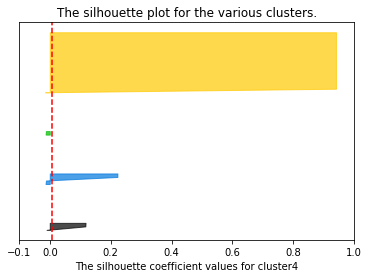

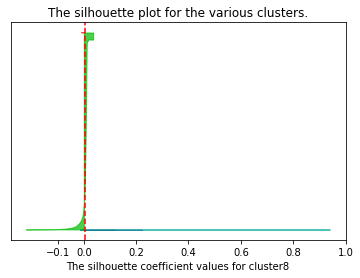

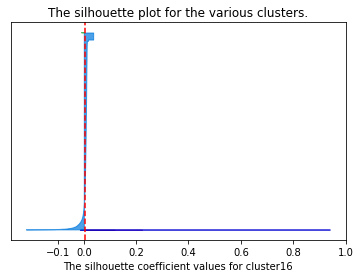

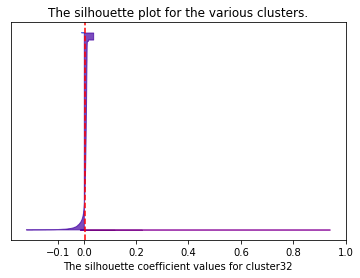

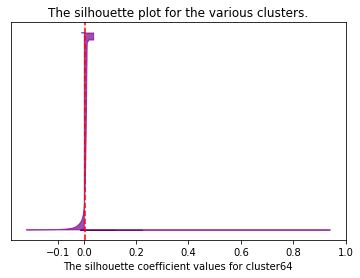

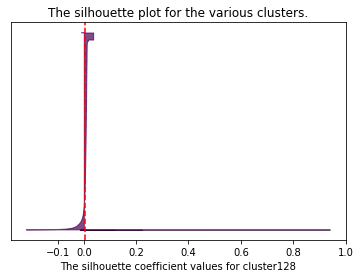

In [0]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

sse = {}
sil_coeff = {}
for n_clusters in cluster_range:
  print("Starting iteration " + "{0}".format(n_clusters))
  fig, (ax1) = plt.subplots(1, 1)
  # YOUR CODE HERE
  clusterer = MiniBatchKMeans(n_clusters=8, random_state=0, batch_size=8)
  # YOUR CODE HERE
  document_matrix = ngram_document_term_matrix# YOUR FEATURES
  cluster_labels = clusterer.fit_predict(document_matrix)

  sse[n_clusters] = clusterer.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(document_matrix, cluster_labels)
  print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(document_matrix, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        #ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
  ax1.set_title("The silhouette plot for the various clusters.")
  ax1.set_xlabel("The silhouette coefficient values for cluster" + str(n_clusters))

  # The vertical line for average silhouette score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

- What's your best silhouette score?  Is this a 'good' score? 

#### Distortion
 - A simpler evaluation than the silhouette plots is a simple graph of distortion over time.
 - A plot of the distortion vs number of clusters.

In [0]:
sse

{4: 24078.108399525474,
 8: 24078.108399525474,
 16: 24078.108399525474,
 32: 24078.108399525474,
 64: 24078.108399525474,
 128: 24078.108399525474}

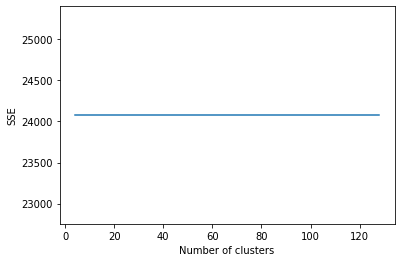

In [0]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

#### Elbow method

The code below plots K-Means using the [Elbow method](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) to select K using the helpful YellowBrick library. You may try this with KMeans vs MiniBatchKMeans as well as other values for K. 

In [0]:
from yellowbrick.cluster import KElbowVisualizer
# Instantiate the clustering model and visualizer
model = KMeans(init='k-means++', n_init=3, random_state=42)
# Multiple metrics are available, see the documentation for details.
# Try varying the number of K to see a better example, but recall larger values 
# will be slower to run. 
visualizer = KElbowVisualizer(model, metric='silhouette', k=(6, 12))
visualizer.fit(document_matrix)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Good value of K?
 - What is a 'good value' of K for this data? Justify your decision. 


### Optional additional exploration
- We only looked at KMeans in this lab.  SKLearn has many more types of clustering available.  This includes [hierachical clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) we discussed in lecture.
- You may also see this [article comparing clustering algorithms](https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html) that examines additional SKLearn clustering models.   
- [Latent Dirichlet Allocation](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation) (LDA) is another commonly used clustering algorithm with a probabilistic interpretation (we'll see foundations of this in the coming lecture)

## Summary 

In this lab we covered a lot of practical ground:
- We used Sci-kit Learn to vectorize text using bag-of-words representation with one-hot encoding and TF-IDF weights
- Ran KMeans clustering on Reddit data and used it to explore data.
- Evaluated different clusterings using the elbow method and silhouette scores. 


Next time we'll perform more advanced language prediction tasks focusing on modeling sequences of text.
